In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use(['dark_background'])
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
import pickle
from collections import OrderedDict
from hyperopt import fmin, tpe, hp, Trials, space_eval, plotting
from tflite2xcore.model_generation import utils
import tensorflow as tf
from sklearn.externals import joblib
utils.set_all_seeds(42)

/home/luismata/ai_tools/ai_tools_gpu_venv/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/luismata/ai_tools/ai_tools_gpu_venv/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [2]:
SEARCH_SPACE = OrderedDict([('learning_rate',
                             hp.loguniform('learning_rate', np.log(0.01), np.log(0.5))),
                            ('epochs',
                             hp.choice('epochs', range(1, 51, 1))),
                            ('batch_size',
                             hp.choice('batch_size', [32, 64, 128, 256, 512])),
                            ('l1_reg',
                             hp.choice('l1_reg', np.arange(1e-5, 2e-4, 1e-6)))
                           ])
STATIC_PARAMS = {'boosting': 'gbdt',
                'objective':'binary',
                'metric': 'auc',
                'num_threads': 12,
                }
# Data
data = utils.prepare_MNIST(False, simard=False, padding=0)

for k, v in data.items():
    print(f"Prepped data[{k}] with shape: {v.shape}")

Prepped data[x_train] with shape: (4096, 28, 28, 1)
Prepped data[x_test] with shape: (1024, 28, 28, 1)
Prepped data[x_val] with shape: (100, 28, 28, 1)
Prepped data[y_train] with shape: (4096,)
Prepped data[y_test] with shape: (1024,)
Prepped data[y_val] with shape: (100,)


In [3]:
def train_evaluate(params):
    core_model = tf.keras.Sequential(
        name='logistic_regression',
        layers=[
            tf.keras.layers.Flatten(input_shape=(28, 28, 1), name='input'),
            tf.keras.layers.Dense(10,
                                  activation='softmax',
                                  kernel_regularizer=tf.keras.regularizers.l1(params['l1_reg']))
        ]
    )
    core_model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=tf.keras.optimizers.RMSprop(learning_rate=params['learning_rate']),
        metrics=['accuracy'])
    core_model.fit(
        data['x_train'], data['y_train'],
        validation_data=(data['x_test'], data['y_test']),
        batch_size=params['batch_size'],
        verbose=0,
        epochs=params['epochs']
    )
    _, accuracy = core_model.evaluate(data['x_test'], data['y_test'])
    return accuracy

def objective(params):
    all_params = {**params, **STATIC_PARAMS}
    return -1.0 * train_evaluate(all_params)

In [4]:
trials = Trials()
HPO_PARAMS = {'max_evals': 1000,
              'trials': trials
             }
best = fmin(
    fn=objective,
    space=SEARCH_SPACE,
    algo=tpe.rand.suggest,
    **HPO_PARAMS
)

.903320312
 96%|█████████▋| 965/1000 [31:11<01:55,  3.29s/trial, best loss: -0.9033203125] - 0s 63us/sample - loss: 1.6522 - accuracy: 0.8584

 97%|█████████▋| 966/1000 [31:16<01:47,  3.15s/trial, best loss: -0.9033203125] - ETA: 0s - loss: 0.4501 - accuracy: 0.9688
 97%|█████████▋| 966/1000 [31:16<01:47,  3.15s/trial, best loss: -0.903320312
 97%|█████████▋| 966/1000 [31:16<01:47,  3.15s/trial, best loss: -0.9033203125] - 0s 26us/sample - loss: 0.8106 - accuracy: 0.8701

 97%|█████████▋| 967/1000 [31:16<01:59,  3.63s/trial, best loss: -0.9033203125] - ETA: 1s - loss: 0.6878 - accuracy: 0.7812
 97%|█████████▋| 967/1000 [31:16<01:59,  3.63s/trial, best loss: -0.903320312
 97%|█████████▋| 967/1000 [31:16<01:59,  3.63s/trial, best loss: -0.9033203125] - 0s 61us/sample - loss: 0.8445 - accuracy: 0.7363

 97%|█████████▋| 968/1000 [31:17<01:24,  2.64s/trial, best loss: -0.9033203125] - ETA: 1s - loss: 4.7732 - accuracy: 0.9062
 97%|█████████▋| 968/1000 [31:17<01:24,  2.64s/trial, best loss: 

In [5]:
print(f"Found minimum after {HPO_PARAMS['max_evals']} trials:")
#print('Best: ', best)
print("")
print('Best values: ', space_eval(SEARCH_SPACE, best))

Found minimum after 1000 trials:

Best values:  {'batch_size': 512, 'epochs': 21, 'l1_reg': 0.00010200000000000005, 'learning_rate': 0.02065826754792354}


In [6]:
best_params = space_eval(SEARCH_SPACE, best)
objective(best_params)

1024/1024 [==============================] - 0s 59us/sample - loss: 0.6393 - accuracy: 0.8398


-0.83984375

1024/1024 [==============================] - 0s 59us/sample - loss: 0.5919 - accuracy: 0.8545
Acc range: (0.904296875, 0.830078125)
Acc median: 0.88671875
Acc average: 0.880703125
avg best error: -0.9033203125


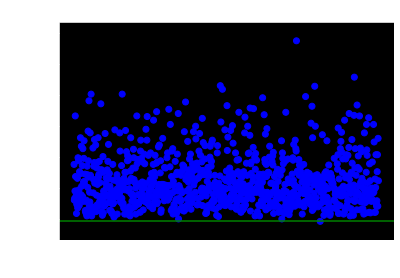

Showing Histogram of 1000 jobs


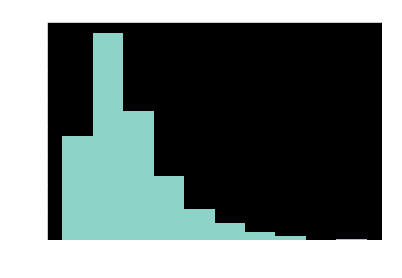

In [7]:
l = [-objective(best_params) for e in range(50)]
maxv = np.max(l)
minv = np.min(l)
print(f"Acc range: ({maxv}, {minv})\nAcc median: {np.median(l)}\nAcc average: {np.average(l)}")
plotting.main_plot_history(trials)
plotting.main_plot_histogram(trials)

In [8]:
joblib.dump(trials, './tune_logistic_regression_trials.pkl')

['./tune_logistic_regression_trials.pkl']

In [9]:
trials = joblib.load('./tune_logistic_regression_trials.pkl')

avg best error: -0.9033203125


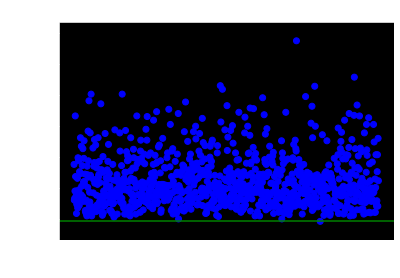

Showing Histogram of 1000 jobs


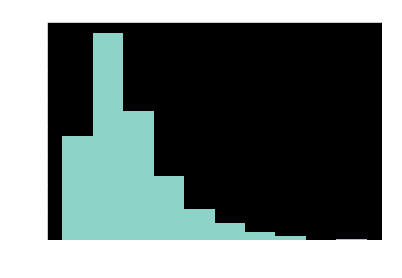

In [10]:
plotting.main_plot_history(trials)
plotting.main_plot_histogram(trials)